In [2]:
import pandas as pd
import json
import numpy as np
import networkx as nx
import multiprocessing
from tqdm.notebook import tqdm
import torch
from fugw_solver.solver import solver

import ot

In [2]:
df = pd.read_csv("results/run.csv")
df

,alpha,rho,k,accuracy
0,0.2,0.1,5,0.84
1,0.2,0.1,10,0.86
2,0.2,0.1,15,0.84
3,0.3,0.1,5,0.82
4,0.3,0.1,10,0.87
...,...,...,...,...
70,0.5,1000.0,10,0.80
71,0.5,1000.0,15,0.82
72,0.6,1000.0,5,0.86
73,0.6,1000.0,10,0.79


In [3]:
df.groupby(by="rho").mean()

,alpha,k,accuracy
rho,,,
0.1,0.4,10.0,0.860667
1.0,0.4,10.0,0.880000
10.0,0.4,10.0,0.886667
100.0,0.4,10.0,0.858667
1000.0,0.4,10.0,0.816667


In [4]:
fgw = df[df["rho"] == 1000]
ind_fgw = fgw["accuracy"].argmax()
fgw_best = fgw.iloc[ind_fgw, :]
fgw_best

alpha          0.60
rho         1000.00
k              5.00
accuracy       0.86
Name: 72, dtype: float64

In [5]:
ind_fugw = df["accuracy"].argmax()
fugw_best = df.iloc[ind_fugw, :]
fugw_best

alpha       0.40
rho         1.00
k           5.00
accuracy    0.91
Name: 21, dtype: float64

In [6]:
def adjacency_to_distance_matrix(adj):
    G = nx.from_numpy_array(adj, create_using=nx.DiGraph)
    length = dict(nx.all_pairs_shortest_path_length(G))
    num_nodes = adj.shape[0]
    distance_matrix = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            try:
                distance_matrix[i, j] = length[i][j]
            except KeyError:  # no path between i and j
                distance_matrix[i, j] = np.inf  # or some large number to denote no path
    return distance_matrix

with open("dataset/mutag.json", 'r') as f:
    data = json.load(f)

features = data["node_feat"]
y = data["y"]
y = list(map(lambda x: x[0], y))
distance_matrices = []
for (sources, targets), num_nodes in zip(data["edge_index"], data["num_nodes"]):
    adj = np.zeros((num_nodes, num_nodes))
    adj[sources, targets] = 1
    distance_matrix = adjacency_to_distance_matrix(adj)
    distance_matrices.append(distance_matrix)

TRAIN_SIZE = 100
features_test = features[TRAIN_SIZE:]
y_test = y[TRAIN_SIZE:]
distance_matrices_test = distance_matrices[TRAIN_SIZE:]

In [ ]:
predict((0,5,None,0.5,features_test, distance_matrices_test, y_test, True))

In [19]:
def predict(args):
    """Predicts the class of the i-th molecule using a k-NN"""
    i, k, rho, alpha, features, distance_matrices, y, pot = args
    source_features = torch.tensor(features[i]).T.float()
    source_geometry = torch.tensor(distance_matrices[i]).float()
    distances = []

    for j, (target_features, target_geometry, classif) in enumerate(zip(features, distance_matrices, y)):
        if j == i:
            continue
        target_features = torch.tensor(target_features).T.float()
        target_geometry = torch.tensor(target_geometry).float()
    
        if pot:
            C1 = ot.dist(source_geometry)
            C2 = ot.dist(target_geometry)
            M = ot.dist(source_features.T, target_features.T)
            Gwg, logw = ot.fused_gromov_wasserstein(M, C1, C2, log=True, alpha=alpha)
            loss = logw["fgw_dist"]
        else:
            P, loss_ls = solver(source_features, target_features, source_geometry, target_geometry, rho=rho, alpha=alpha, nits_bcd=10, nits_uot=100)
            loss = loss_ls[-1]["total"]
        distances.append((loss, classif))

    distances.sort(key=lambda x: x[0])
    distances = distances[:k]
    classes = list(map(lambda x: x[1], distances))
    return 1 if sum(classes) >= (len(classes)/2) else 0

# Multiprocessing
def knn(rho, alpha, k, features, distance_matrices, y, pot=False):
    accuracy = 0
    n = len(features)
    # print(f"Starting the knn for rho={rho}, alpha={alpha}, k={k}")
    args = [(i, k, rho, alpha, features, distance_matrices, y, pot) for i in range(n)]  # Prepare arguments for each process
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        predictions = list(tqdm(pool.imap(predict, args), total=n))

    # Calculate accuracy based on the returned predictions
    for i, prediction in enumerate(predictions):
        accuracy += (prediction == y[i])
    accuracy /= n
    print(f"The accuracy with rho={rho}, alpha={alpha}, k={k}{', with pot' if pot else ''}, is {accuracy}")
    return accuracy

In [21]:
test_accuracy_fgw = knn(rho=fgw_best.iloc[1], alpha=fgw_best.iloc[0], k=int(fgw_best.iloc[2]), features=features_test, distance_matrices=distance_matrices_test, y=y_test)
test_accuracy_fugw = knn(rho=fugw_best.iloc[1], alpha=fugw_best.iloc[0], k=int(fugw_best.iloc[2]), features=features_test, distance_matrices=distance_matrices_test, y=y_test)
test_accuracy_fgw, test_accuracy_fugw

  0%|          | 0/88 [00:00<?, ?it/s]

The accuracy with rho=1000.0, alpha=0.6, k=5, is 0.7272727272727273


  0%|          | 0/88 [00:00<?, ?it/s]

The accuracy with rho=1.0, alpha=0.4, k=5, is 0.7613636363636364


(0.7272727272727273, 0.7613636363636364)

### Comparaison with the pot solver

In [24]:
df_ot = pd.read_csv("results/run_ot.csv")
df_ot

,alpha,k,accuracy
0,0.2,5,0.88
1,0.2,10,0.86
2,0.2,15,0.87
3,0.3,5,0.88
4,0.3,10,0.86
5,0.3,15,0.87
6,0.4,5,0.88
7,0.4,10,0.86
8,0.4,15,0.87
9,0.5,5,0.88


In [25]:
ind_ot_fugw = df_ot["accuracy"].argmax()
fgw_ot_best = df_ot.iloc[ind_ot_fugw, :]
fgw_ot_best.to_list()

[0.2, 5.0, 0.88]

In [26]:
test_accuracy_fgw_pot = knn(rho="not_used", alpha=fgw_ot_best[0], k=int(fgw_ot_best[1]), features=features_test, distance_matrices=distance_matrices_test, y=y_test, pot=True)
test_accuracy_fgw_pot

/tmp/ipykernel_918826/3950999299.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_accuracy_fgw_pot = knn(rho="not_used", alpha=fgw_ot_best[0], k=int(fgw_ot_best[1]), features=features_test, distance_matrices=distance_matrices_test, y=y_test, pot=True)


  0%|          | 0/88 [00:00<?, ?it/s]

The accuracy with rho=not_used, alpha=0.2, k=5, with pot, is 0.6931818181818182


0.6931818181818182

### Leave One Out

In [48]:
import matplotlib.pyplot as plt

In [49]:
df_loo = pd.concat([pd.read_csv("results/run_loo.csv"), pd.read_csv("results/run_loo_2.csv"), pd.read_csv("results/run_loo_3.csv")])
df_loo

,alpha,rho,k,accuracy
0,0.3,0.1,5,0.813830
1,0.3,0.1,10,0.819149
2,0.3,0.1,15,0.835106
3,0.4,0.1,5,0.808511
4,0.4,0.1,10,0.819149
...,...,...,...,...
5,0.9,10.0,5,0.861702
6,0.1,100.0,5,0.856383
7,0.9,100.0,5,0.835106
8,0.1,1000.0,5,0.840426


In [50]:
df_loo.groupby("k").mean()["accuracy"]

k
5     0.831797
10    0.825988
15    0.818845
Name: accuracy, dtype: float64

In [51]:
df_loo.groupby("rho").mean()["accuracy"]

rho
0.1       0.819611
1.0       0.840657
10.0      0.841582
100.0     0.821924
1000.0    0.806660
Name: accuracy, dtype: float64

In [52]:
df_loo.groupby("alpha").mean()["accuracy"]

alpha
0.1    0.840426
0.2    0.821986
0.3    0.816667
0.4    0.820567
0.5    0.825887
0.6    0.830496
0.7    0.831560
0.8    0.827660
0.9    0.835106
Name: accuracy, dtype: float64

In [53]:
ind_best = df_loo["accuracy"].argmax()
best_acc = df_loo.iloc[ind_best, :]
best_acc

alpha       0.60000
rho         1.00000
k           5.00000
accuracy    0.87234
Name: 24, dtype: float64

In [56]:
df_5 = df_loo[df_loo["k"] == 5]
df_5 = df_5[df_5["alpha"] > 0.15]
df_5 = df_5.sort_values("alpha")

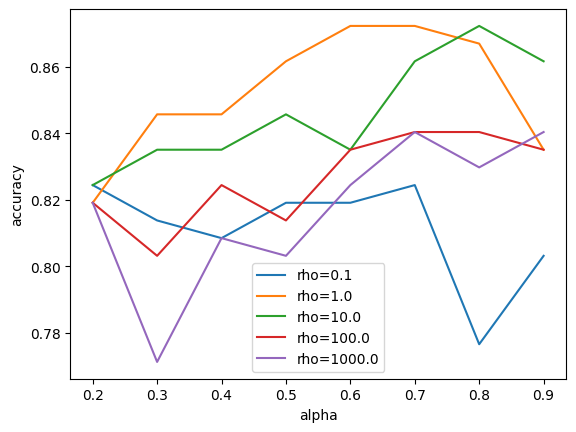

In [64]:
for i, (rho, df) in enumerate(df_5.groupby("rho")):
    plt.plot(df["alpha"], df["accuracy"], label=f"rho={rho}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.savefig("figures/mutag_alpha.png")
plt.show()